In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle

from DrlLibs.evaluate import evaluate_drl_agent
from DrlLibs.DRL_config import (
    get_algorithm_config, 
    get_training_config,
    print_algorithm_info
)
from DrlLibs import create_environment, load_and_evaluate
from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicyDemoAdaptiveAlpha, PolicySimulator, createEnv

In [2]:
configIdx = 0
(envParams, predictorParams) = (getEnvConfig(configIdx), getPredictorConfig(configIdx))
visualizeEnvConfig(envParams)
visualizePredictorConfig(predictorParams)
simEnv = createEnv(envParams, f'Results/TrafficData')
simEnv.selectMode(mode="test", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [6]:
# ==== Prepare Policy====
with open(f'Results/MdpPolicy/mdpKernel_config{configIdx}.pkl', 'rb') as f:
    mdpPolicy = pickle.load(f)
adaptiveAlphaPolicy = PolicyDemoAdaptiveAlpha(envParams)

# ==== Evaluate MDP-Policy====
policySimulator = PolicySimulator(mdpPolicy, simEnv)
rewardRecord_mdp, _ = policySimulator.runSimulation(mdpPolicy, num_epochs=2500, mode="test", type="data")
rewardRecord_adaptive, _ = policySimulator.runSimulation(adaptiveAlphaPolicy, num_epochs=2500, mode="test", type="data")

# ==== Evaluate DRL-Policy====
model, eval_results = load_and_evaluate(
    envParams, simEnv, 
    f'Results/DrlAgent/config{configIdx}.zip', 
    'SAC',
    obvMode="perfect",
    episode_timesteps=2500,
)

Loading SAC model from Results/DrlAgent/config0.zip

Evaluating SAC Agent
Evaluation Results:
  Average Reward: -0.0142 ± 0.0085
  Average Loss Rate: 0.0143 ± 0.0004
  Average Alpha: 0.9132


Average Reward MDP:      0.0058
Average Reward Adaptive: 0.0134
Average Reward DRL:      0.0142


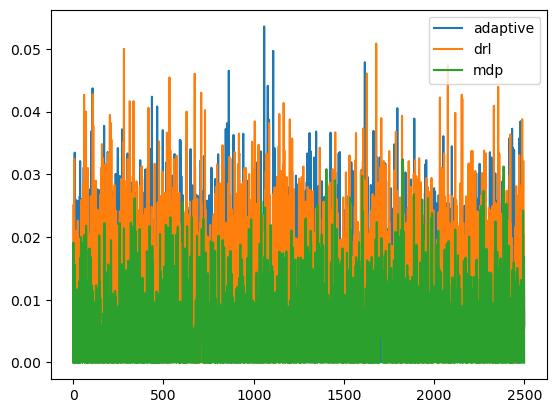

In [8]:
rewardRecord_drl = -1*np.array(eval_results['episode_rewards'])
print(f"Average Reward MDP:      {np.mean(rewardRecord_mdp):.4f}")
print(f"Average Reward Adaptive: {np.mean(rewardRecord_adaptive):.4f}")
print(f"Average Reward DRL:      {np.mean(rewardRecord_drl):.4f}")

plt.plot(rewardRecord_adaptive, label="adaptive")
plt.plot(rewardRecord_drl, label="drl")
plt.plot(rewardRecord_mdp, label="mdp")
plt.legend()
plt.show()

C:\Users\Ye\AppData\Local\Temp\ipykernel_7760\391090932.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


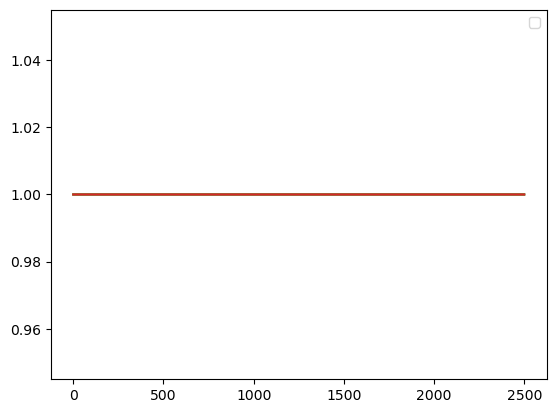

In [ ]:
env = create_environment(envParams, simEnv, obvMode="perfect", num_episodes=5000)
drl_actions = eval_results['episode_actions']
alpha_record = []
w_record = []
r_record = []
M_record = []
for i in range(2500):
    actions = env.unwrapped._from_dl_action_to_env_action(drl_actions[i])
    (w, r, M, alpha) = actions
    alpha_record.append(alpha)
    w_record.append(w)
    r_record.append(r)
    M_record.append(M)

#plt.plot(alpha_record)
plt.plot(w_record)
#plt.plot(M_record)
plt.legend()
plt.show()